## The genomic regions in question

In `03_compartments.ipynb` we extracted the genomic intervals of A compartments on all cell types in all combinations of the following parameters:

* Cell type: fibroblast, spermatocyte, pachytene spermatocyte, round spermatid, sperm
* Chromosome: X
* E1 restriction: full-chromosome, chromosome arms, 10Mb windows
* Resolution: 100 kb, 500 kb

The following parameter was only changed for 100kb resolution:
* Smoothing: No smoothing, 5 bins (500kb) 

Resulting in **45** .csv files. They are saved to `../results/compartments/`.


### Load the data

In [21]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/compartments/'

# Create a dictionary to store the DataFrames
dataframes = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_a_comp_coords_', '_')
        key = os.path.splitext(key)[0]
        dataframes[key] = pd.read_csv(filepath)

# The `dataframes` dictionary now contains the DataFrames
dataframes.keys()

ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


## Time to unleash `genominterv` on the .csv files


### Modules

In [ ]:
import genominterv
import pandas as pd

### Define a plotting function

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

def plot_intervals(query=None, annot=None, **kwargs):

    tups = []
    if query is not None:
        tups.append(('query', query))
    if annot is not None:
        tups.append(('annot', annot))
    tups.extend(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = label
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)
    fig, axes = plt.subplots(gr.ngroups, 1, figsize=(8, 1.5*gr.ngroups), 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = np.array([axes])
    
    # with plt.style.context(('default')):

    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            axes[i].hlines(y, df.start.tolist(), df.end.tolist(), alpha=0.5, lw=5, colors=f'C{y[0]}')
            delta = len(labels)/10
            axes[i].vlines(df.start.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')
            axes[i].vlines(df.end.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)
    plt.tight_layout()

### Test with a subsample of the data

Tests for round_spermatid_100kb_arms_smoothed
Proximity: TestResult(statistic=0.30453333333333343, pvalue=0.0218)
Jaccard: 0.035452077710120426

Tests for round_spermatid_100kb_arms
Proximity: TestResult(statistic=0.4966666666666664, pvalue=0.0004)
Jaccard: 0.03919324886292875

Tests for round_spermatid_100kb_10Mb
Proximity: TestResult(statistic=0.40763636363636385, pvalue=0.0081)
Jaccard: 0.04849757649383784

Tests for round_spermatid_100kb_10Mb_smoothed
Proximity: TestResult(statistic=0.4469090909090912, pvalue=0.0051)
Jaccard: 0.0451828466064548



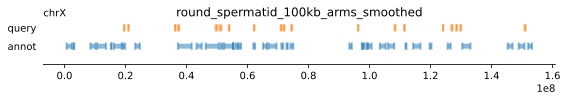

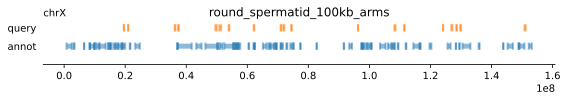

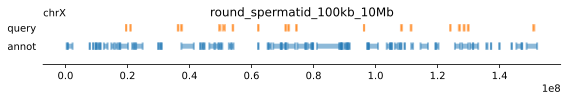

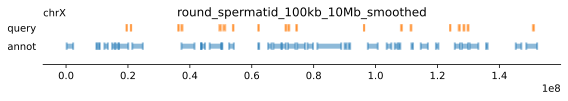

In [42]:
from genominterv import proximity_test, interval_collapse, interval_diff, jaccard

annot = dataframes['fibroblast_500kb_arms']
query = ech90

#plot_intervals(query=query, annot=annot)

for key,annot in dataframes.items():
    # Filter out subset
    if ('round_spermatid_100') in key and not 'full' in key:
        # Plot the intervals
        plot_intervals(query=query, annot=annot)
        plt.title(key)

        # Do a proximity test
        print(f"Tests for {key}")
        annot_collapsed = interval_collapse(annot)
        non_ovl_query = interval_diff(query, annot_collapsed)
        print("Proximity:", proximity_test(non_ovl_query, annot_collapsed))
        print("Jaccard:", jaccard(query, annot))
        print()



### Bootstrap to get a p-value

In [ ]:
from genominterv import bootstrap

annot = dataframes['round_spermatid_100kb_arms']
chromsizes = pd.read_csv('../data/links/ucsc_ref/misc/rheMac10.filtered.chrom.sizes', sep='\t', index_col='chrom', header=None, names=['chrom','size']).to_dict()['size']
#display(chromsizes)

@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard(query, annot)

jacccard_stat, p_value = jaccard_bootstrap(query, annot)

{'chr1': 223616942,
 'chr2': 196197964,
 'chr3': 185288947,
 'chr4': 169963040,
 'chr5': 187317192,
 'chr6': 179085566,
 'chr7': 169868564,
 'chr8': 145679320,
 'chr9': 134124166,
 'chr10': 99517758,
 'chr11': 133066086,
 'chr12': 130043856,
 'chr13': 108737130,
 'chr14': 128056306,
 'chr15': 113283604,
 'chr16': 79627064,
 'chr17': 95433459,
 'chr18': 74474043,
 'chr19': 58315233,
 'chr20': 77137495,
 'chrX': 153388924,
 'chrY': 11753682}

In [59]:
jacccard_stat, p_value

(0.03919324886292875, 0.285)